In [1]:
import pandas as pd
import seaborn as sns
import rf
import os
import pygmt
import numpy as np

In [2]:
shubhdf = pd.read_csv(
    "/g/data/ha3/am3591/agrawal.txt",
    sep="\s+",
    names=("Network", "Station", "Latitude", "Longitude", "nRF", "TPsb", "Estimated Depth"),
    skiprows=2
)
shubhdf.set_index("Station", inplace=True)
shubhdf.drop(labels=["nRF", "Estimated Depth"], axis=1, inplace=True)

In [3]:
all_analysis_dir = "/g/data/ha3/am3591/analysis2/ALL-analysis/"
latest_run = max(
    [
        os.path.join(all_analysis_dir, d)
        for d in os.listdir(all_analysis_dir)
        if os.path.isdir(os.path.join(all_analysis_dir, d))
    ],
    key=os.path.getmtime,
)
delaysdf = pd.read_csv(
    os.path.join(latest_run, "delays.txt"),
    sep="\s+",
    names=("Network", "Station", "Longitude", "Latitude", "TPsb"),
)
delaysdf.set_index("Station", inplace=True)

In [23]:
df = delaysdf.join(shubhdf, how="inner", lsuffix=None, rsuffix="_shubh")
df.Network.fillna(df.Network_shubh, inplace=True)
df.Longitude.fillna(df.Longitude_shubh, inplace=True)
df.Latitude.fillna(df.Latitude_shubh, inplace=True)
df.drop(labels=["Network_shubh", "Latitude_shubh", "Longitude_shubh"], axis=1, inplace=True)
df.rename(columns={"TPsb": "TPsb_me"}, inplace=True)
df["TPsb_diff"] = (df["TPsb_me"] - df["TPsb_shubh"]).abs()
df = df[~df.index.duplicated()]
df.head()

,Network,Longitude,Latitude,TPsb_me,TPsb_shubh,TPsb_diff
Station,,,,,,
AQT08,1Q,139.5949,-24.7972,0.86,0.71,0.15
AQTF2,1Q,141.3096,-24.6950,0.80,0.73,0.07
AQTG1,1Q,140.7598,-24.9475,0.84,0.88,0.04
AQTG2,1Q,141.5433,-25.3829,0.86,0.90,0.04
AQTG3,1Q,141.8919,-24.9620,1.04,1.09,0.05


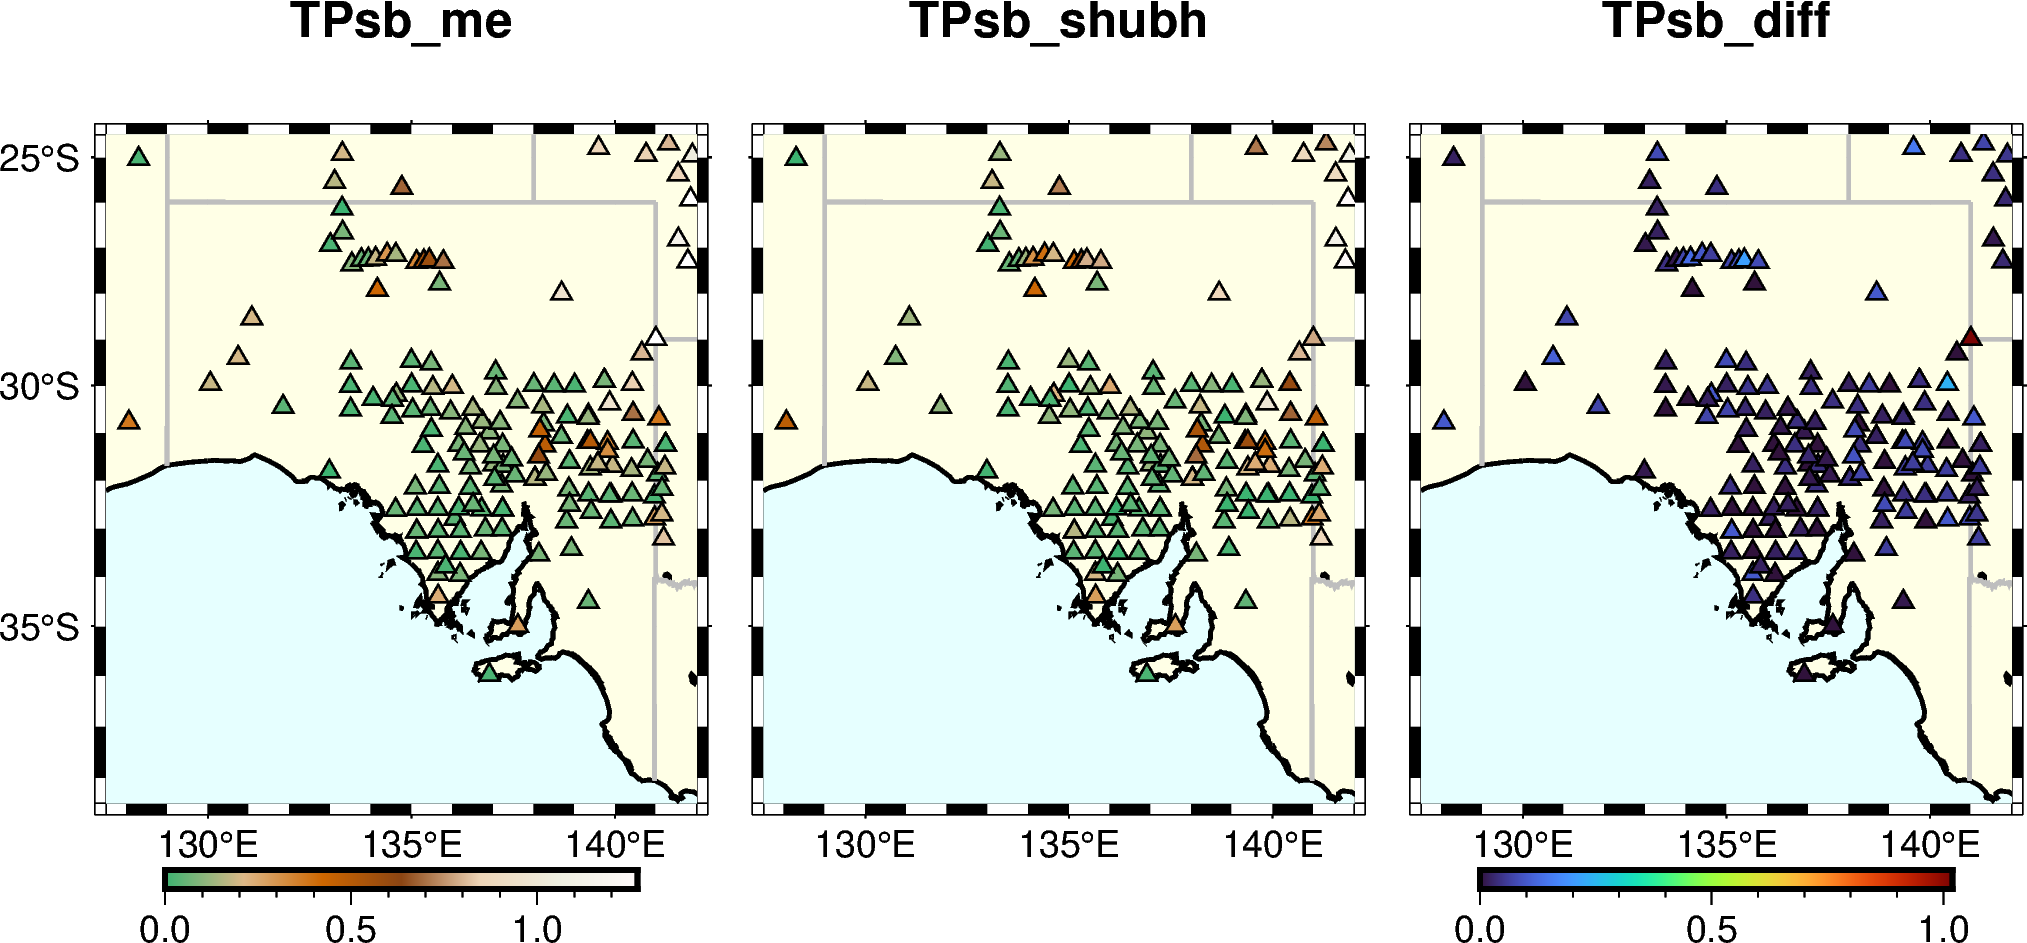

In [25]:
fig = pygmt.Figure()
pygmt.config(FONT_TITLE="12")
lons = df["Longitude"]
lats = df["Latitude"]
ln_min, ln_max = (127.5, 142)
lt_min, lt_max = (-38.5, -24.5)
region = [ln_min, ln_max, lt_min, lt_max]
_width = 5
projection = f"M12/11/{_width}c"
cbar_position = "JBC"

with fig.subplot(
    nrows=1, ncols=3, subsize=(f"{_width}c", "6c"), sharey="l", frame="WSne",
):
    for j, d in enumerate(["TPsb_me", "TPsb_shubh", "TPsb_diff"]):
        with fig.set_panel(panel=j):
            frame = f"+t{d}"
            fig.basemap(region=region, frame=frame, projection=projection)
            fig.coast(
                shorelines=1,
                land="#ffffe6",
                water="#e6ffff",
                borders="2/1p,grey",
                projection=projection,
                region=region,
            )
            if d in ["TPsb_me", "TPsb_shubh"]:
                _mn = (df[["TPsb_me", "TPsb_shubh"]].min()).min()
                _mx = (df[["TPsb_me", "TPsb_shubh"]].max()).min()
            else:
                _mn = df["TPsb_diff"].min()
                _mx = df["TPsb_diff"].max()
            pygmt.makecpt(cmap="turbo" if d == "TPsb_diff" else "dem3", series=[_mn, _mx])
            fig.plot(
                x=lons,
                y=lats,
                projection=projection,
                region=region,
                style=f"tc",
                pen="0.5p",
                fill=df[d],
                cmap=True,
                size=np.full_like(lons, 0.2),
            )
            if d in ["TPsb_me", "TPsb_diff"]:
                fig.colorbar(frame="af", position=f"{cbar_position}")
fig.show()


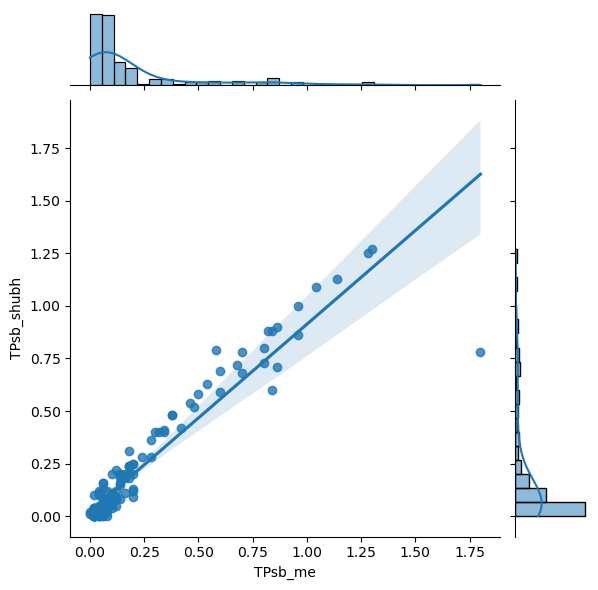

In [29]:
sns.jointplot(data=df, x="TPsb_me", y="TPsb_shubh", kind="reg")


In [32]:
s = df["TPsb_diff"].std()
df[df["TPsb_diff"] > 2 * s]

,Network,Longitude,Latitude,TPsb_me,TPsb_shubh,TPsb_diff
Station,,,,,,
CU01,1F,140.99979,-28.99593,1.80,0.78,1.02
CU10,1F,140.42280,-29.96164,0.84,0.60,0.24
MAL54,3G,135.43654,-27.28651,0.58,0.79,0.21
